<a href="https://colab.research.google.com/github/hsiangwei0903/Fine-Grained-Object-Recognition/blob/dev%2Fravi%2Ftent/TrainingAndTentAndAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader, ConcatDataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
import numpy as np
import statistics
%matplotlib inline

In [ ]:
cd /content/drive/My Drive/UW/2021-22_Senior/Capstone/ENGINE: Wyze/

/content/drive/.shortcut-targets-by-id/1beXLuTyfFnOo3t19p65wHXF-qaxghvjI/ENGINE: Wyze


In [ ]:
dataset = ImageFolder('./Images/stanfordImages/Images')

In [ ]:
dataset.classes

['n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih-Tzu',
 'n02086646-Blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-Rhodesian_ridgeback',
 'n02088094-Afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-Walker_hound',
 'n02089973-English_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-Irish_wolfhound',
 'n02091032-Italian_greyhound',
 'n02091134-whippet',
 'n02091244-Ibizan_hound',
 'n02091467-Norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-Saluki',
 'n02092002-Scottish_deerhound',
 'n02092339-Weimaraner',
 'n02093256-Staffordshire_bullterrier',
 'n02093428-American_Staffordshire_terrier',
 'n02093647-Bedlington_terrier',
 'n02093754-Border_terrier',
 'n02093859-Kerry_blue_terrier',
 'n02093991-Irish_terrier',
 'n02094114-Norfolk_terrier',
 'n02094258-Norwi

In [ ]:
breeds = []

def rename(name):
    return ' '.join(' '.join(name.split('-')[1:]).split('_'))

for n in dataset.classes:
    breeds.append(rename(n))

In [ ]:
len(dataset)


20580

In [ ]:
random_seed = 45
torch.manual_seed(random_seed);
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size


train_size, val_size, test_size

(12966, 1440, 6174)

In [ ]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(12966, 1440, 6174)

n02107908-Appenzeller
<class 'PIL.Image.Image'>


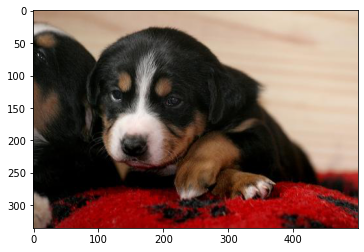

In [ ]:
img, label = train_ds[6]
print(dataset.classes[label])
plt.imshow(img)
print(type(img))

In [ ]:
class DogBreedDataset(Dataset):
    
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)  
            return img, label

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),    
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
])

corrupt_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.GaussianBlur(kernel_size=(15,15), sigma=(3, 3)),
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=(.5,1.5), saturation=(1,1.25)),
    transforms.ToTensor(),         
])

augment_transform_1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandAugment(num_ops=2, magnitude=25),
    transforms.ToTensor()       
])

augment_transform_2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandAugment(num_ops=4, magnitude=20),
    transforms.ToTensor()       
])

augment_transform_3 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandAugment(num_ops=6, magnitude=15),
    transforms.ToTensor()       
])

In [ ]:
train_dataset = DogBreedDataset(train_ds, train_transform)
val_dataset = DogBreedDataset(val_ds, val_transform)
test_dataset = DogBreedDataset(test_ds, test_transform)
corrupt_test_dataset = DogBreedDataset(test_ds, corrupt_transform)

augment1_train_dataset = DogBreedDataset(train_ds, augment_transform_1)
augment2_train_dataset = DogBreedDataset(train_ds, augment_transform_2)
augment3_train_dataset = DogBreedDataset(train_ds, augment_transform_3)

train_dataset_augment1 = ConcatDataset([train_dataset, augment1_train_dataset])
train_dataset_augment2 = ConcatDataset([train_dataset, augment1_train_dataset, augment2_train_dataset])
train_dataset_augment3 = ConcatDataset([train_dataset, augment1_train_dataset, augment2_train_dataset, augment3_train_dataset])


In [ ]:
print(len(train_dataset_augment1))
print(len(train_dataset_augment2))
print(len(train_dataset_augment3))

25932
38898
51864


89


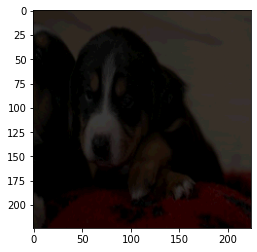

In [ ]:
img, label = train_dataset_augment1[12972]
print(label)
plt.imshow(img.permute(1,2,0))

In [ ]:
batch_size =64
workers = 6
# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=workers, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=workers, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=workers, pin_memory=True)
corrupt_test_dl = DataLoader(corrupt_test_dataset, batch_size*2, num_workers=workers, pin_memory=True)

train_augment1_dl = DataLoader(train_dataset_augment1, batch_size, shuffle=True, num_workers=workers, pin_memory=True)
train_augment2_dl = DataLoader(train_dataset_augment2, batch_size, shuffle=True, num_workers=workers, pin_memory=True)
train_augment3_dl = DataLoader(train_dataset_augment3, batch_size, shuffle=True, num_workers=workers, pin_memory=True)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


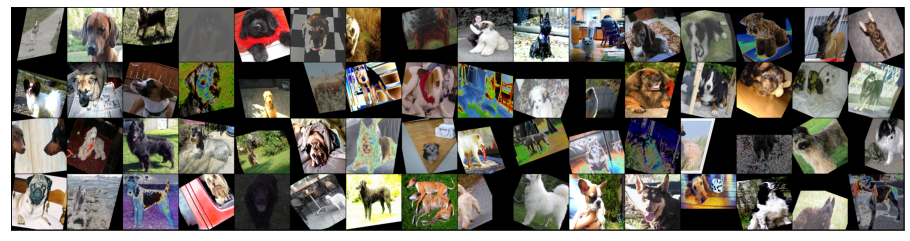

In [ ]:
show_batch(train_augment3_dl)


In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    # print(outputs[0])
    # print(preds[0])
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        return loss
    
    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        # print(out[0])
        # print(targets[0])
        loss = F.nll_loss(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}
    
    def wyze_validation_step(self, batch):
        img, targets = batch
        outs = self(img)                                  # Change model object here
        _, preds = torch.max(outs, dim=1)
        labelslist = targets.detach().tolist()
        predlist = preds.detach().tolist()

        labelslist = [our_dataset.classes[i] for i in labelslist]
        print(labelslist)
        predlist = [dataset.classes[i] for i in predlist]
        print(predlist)
        
        labelsarray = np.array(labelslist)
        predarray = np.array(predlist)
        acc = (((np.sum(labelsarray == predarray)) / len(preds)) * 100)
        print(acc)
        return {'val_acc':acc, 'val_loss': 0}
    
    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
    
    def validation_epoch_end_wyze(self, outputs):
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = statistics.mean(batch_acc)
        return {'val_acc': epoch_acc}
        
    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))
        

In [ ]:
class DogBreedPretrainedResnet34(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
class DogBreedPretrainedResnet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model2 = DogBreedPretrainedResnet34()
model2

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

DogBreedPretrainedResnet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

In [ ]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
train_augment1_dl = DeviceDataLoader(train_augment1_dl, device)
train_augment2_dl = DeviceDataLoader(train_augment2_dl, device)
train_augment3_dl = DeviceDataLoader(train_augment3_dl, device)


# moving model to gpu
to_device(model2, device);

cuda


In [ ]:
# check the model 
def try_batch(dl):
    for imgs, labels in dl:
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = model2(imgs)                                  # Change model object here
        print("outs.shape :", outs.shape)
        print("outs : ", outs)
        break
        
try_batch(train_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images shape :  torch.Size([64, 3, 224, 224])
labels :  tensor([ 83,  30, 101, 109,  45,   6, 102,  71, 100, 117,  20,  70,   4, 112,
         11,  85,  36,  70,  55,  70,  31,  66,  92,  50,  60, 104,  68,   7,
         92,  52,  53,  23,  44,  62, 113,  39,   8,  38,  62,  99, 118,  30,
        107,  27,  47,  26,   6,  57,  35,   5,  71,  55, 115,  32,  87,  62,
         20,  89, 102,  59,  75,  17,  92,  59], device='cuda:0')
outs.shape : torch.Size([64, 120])
outs :  tensor([[-5.4149, -4.9477, -6.4243,  ..., -4.2059, -4.1544, -5.3923],
        [-5.1205, -4.5803, -6.9836,  ..., -4.7531, -5.0676, -5.0723],
        [-5.4775, -5.2381, -6.6451,  ..., -5.0793, -6.3188, -4.7513],
        ...,
        [-5.4886, -4.9316, -6.6495,  ..., -4.4065, -5.8848, -5.4535],
        [-4.8678, -5.2268, -6.5814,  ..., -4.6119, -5.8638, -4.6593],
        [-4.8900, -5.3780, -7.1838,  ..., -4.8574, -5.6816, -4.5403]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


In [ ]:
from tqdm.notebook import tqdm


In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        
        # Training phase
        model.train()       
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            
            # calculates gradients
            loss.backward()
            
            # check gradient clipping 
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            # perform gradient descent and modifies the weights
            optimizer.step()
            
            # reset the gradients
            optimizer.zero_grad()
            
            # record and update lr
            lrs.append(get_lr(optimizer))
            
            # modifies the lr value
            sched.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
        
    return history
        
    

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    # for batch in val_loader:
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def evaluate_wyze(model, val_loader):
    # for batch in val_loader:
    outputs = [model.wyze_validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end_wyze(outputs)

In [ ]:
evaluate(model2, val_dl)                 # change model object here


In [ ]:
model3 = DogBreedPretrainedResnet34()
to_device(model3, device)

In [ ]:
model4 = DogBreedPretrainedResnet18()
to_device(model4, device)

In [ ]:
# set hyperparams
num_epochs = 15
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [ ]:
history = fit_one_cycle(num_epochs, max_lr, model3, train_augment3_dl, val_dl, weight_decay, grad_clip, opt_func)


  0%|          | 0/811 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0] : train_loss: 2.5652, val_loss: 0.9524, val_acc: 0.7201


  0%|          | 0/811 [00:00<?, ?it/s]

Epoch [1] : train_loss: 1.1436, val_loss: 1.0801, val_acc: 0.6764


  0%|          | 0/811 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.9940, val_loss: 1.3205, val_acc: 0.6328


  0%|          | 0/811 [00:00<?, ?it/s]

Epoch [3] : train_loss: 0.8620, val_loss: 1.3146, val_acc: 0.6445


  0%|          | 0/811 [00:00<?, ?it/s]

Epoch [4] : train_loss: 0.7170, val_loss: 1.4115, val_acc: 0.6380


  0%|          | 0/811 [00:00<?, ?it/s]

Epoch [5] : train_loss: 0.5973, val_loss: 1.4344, val_acc: 0.6393


  0%|          | 0/811 [00:00<?, ?it/s]

Epoch [6] : train_loss: 0.5044, val_loss: 1.3612, val_acc: 0.6699


  0%|          | 0/811 [00:00<?, ?it/s]

Epoch [7] : train_loss: 0.4219, val_loss: 1.2929, val_acc: 0.7018


  0%|          | 0/811 [00:00<?, ?it/s]

Epoch [8] : train_loss: 0.3546, val_loss: 1.3114, val_acc: 0.6810


  0%|          | 0/811 [00:00<?, ?it/s]

Epoch [9] : train_loss: 0.2774, val_loss: 1.2249, val_acc: 0.7090


  0%|          | 0/811 [00:00<?, ?it/s]

Epoch [10] : train_loss: 0.2336, val_loss: 1.2277, val_acc: 0.7116


  0%|          | 0/811 [00:00<?, ?it/s]

Epoch [11] : train_loss: 0.1820, val_loss: 1.1843, val_acc: 0.7298


  0%|          | 0/811 [00:00<?, ?it/s]

Epoch [12] : train_loss: 0.1387, val_loss: 1.1530, val_acc: 0.7370


  0%|          | 0/811 [00:00<?, ?it/s]

Epoch [13] : train_loss: 0.1133, val_loss: 1.1387, val_acc: 0.7370


  0%|          | 0/811 [00:00<?, ?it/s]

Epoch [14] : train_loss: 0.1102, val_loss: 1.1182, val_acc: 0.7435


In [ ]:
num_epochs = 5
max_lr = 0.001
# history += fit_one_cycle(num_epochs, max_lr, model3, train_dl, val_dl, weight_decay, grad_clip, opt_func)
fit_one_cycle(num_epochs, max_lr, model3, train_augment3_dl, val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/811 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0] : train_loss: 0.1027, val_loss: 1.1110, val_acc: 0.7396


  0%|          | 0/811 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.1013, val_loss: 1.1022, val_acc: 0.7402


  0%|          | 0/811 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.0981, val_loss: 1.0925, val_acc: 0.7357


  0%|          | 0/811 [00:00<?, ?it/s]

Epoch [3] : train_loss: 0.0950, val_loss: 1.1010, val_acc: 0.7396


  0%|          | 0/811 [00:00<?, ?it/s]

Epoch [4] : train_loss: 0.0886, val_loss: 1.0914, val_acc: 0.7461


[{'lrs': [3.9999999999999996e-05,
   4.0001603248414016e-05,
   4.000641298294622e-05,
   4.001442917146616e-05,
   4.002565176042456e-05,
   4.004008067485219e-05,
   4.0057715818360776e-05,
   4.0078557073144265e-05,
   4.010260429997852e-05,
   4.01298573382236e-05,
   4.016031600582342e-05,
   4.019398009930803e-05,
   4.02308493937946e-05,
   4.027092364298861e-05,
   4.0314202579186235e-05,
   4.036068591327521e-05,
   4.0410373334737746e-05,
   4.046326451165154e-05,
   4.051935909069298e-05,
   4.057865669713915e-05,
   4.064115693486973e-05,
   4.070685938637093e-05,
   4.0775763612736684e-05,
   4.084786915367329e-05,
   4.0923175527500955e-05,
   4.100168223115778e-05,
   4.1083388740203466e-05,
   4.11682945088218e-05,
   4.125639896982521e-05,
   4.134770153465812e-05,
   4.1442201593400976e-05,
   4.153989851477435e-05,
   4.1640791646143076e-05,
   4.174488031352067e-05,
   4.185216382157381e-05,
   4.196264145362718e-05,
   4.207631247166773e-05,
   4.2193176116350176e-

In [ ]:
num_epochs = 5
max_lr = 0.0001
fit_one_cycle(num_epochs, max_lr, model3, train_augment3_dl, val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/811 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0] : train_loss: 0.0859, val_loss: 1.0935, val_acc: 0.7428


  0%|          | 0/811 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.0892, val_loss: 1.0846, val_acc: 0.7422


  0%|          | 0/811 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
weights_fname = 'dog-breed-classifier-resnet34-pretrained-finetuned.pth'
torch.save(model2.state_dict(), weights_fname)

In [ ]:
weights_fname = 'dog-breed-classifier-resnet34-pretrained-finetuned-65-epochs.pth'
torch.save(model3.state_dict(), weights_fname)

In [ ]:
weights_fname = 'dog-breed-classifier-resnet18-pretrained-finetuned-35-epochs.pth'
torch.save(model4.state_dict(), weights_fname)

In [ ]:
weights_fname = 'dog-breed-classifier-resnet34-pretrained-finetuned-25-epochs-aug0.pth'
torch.save(model3.state_dict(), weights_fname)

In [ ]:
weights_fname = 'dog-breed-classifier-resnet34-pretrained-finetuned-25-epochs-aug1.pth'
torch.save(model3.state_dict(), weights_fname)

In [ ]:
weights_fname = 'dog-breed-classifier-resnet34-pretrained-finetuned-25-epochs-aug2.pth'
torch.save(model3.state_dict(), weights_fname)

In [ ]:
weights_fname = 'dog-breed-classifier-resnet34-pretrained-finetuned-25-epochs-aug3.pth'
torch.save(model3.state_dict(), weights_fname)

In [ ]:
history[0].keys()

dict_keys(['val_loss', 'val_acc', 'train_loss', 'lrs'])

In [ ]:
val_loss = []
train_loss = []
val_acc = []
time = list(range(len(history)))
for h in history:
    val_loss.append(h['val_loss'])
    train_loss.append(h['train_loss'])
    val_acc.append(h['val_acc'])

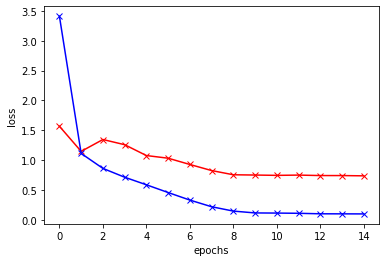

In [ ]:
plt.plot(time, val_loss, c='red', label='val_loss', marker='x')
plt.plot(time, train_loss, c='blue', label='train_loss', marker='x')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

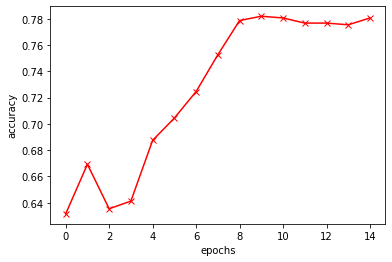

In [ ]:
plt.plot(time, val_acc, c='red', label='accuracy', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
saved_model = DogBreedPretrainedResnet34()
saved_model.load_state_dict(torch.load("/content/drive/MyDrive/UW/2021-22_Senior/Capstone/ENGINE: Wyze/dog-breed-classifier-resnet34-pretrained-finetuned-25-epochs-aug3.pth"))

<All keys matched successfully>

In [ ]:
saved_model_34_65epoch = DogBreedPretrainedResnet34()
saved_model_34_65epoch.load_state_dict(torch.load("/content/drive/MyDrive/UW/2021-22_Senior/Capstone/ENGINE: Wyze/dog-breed-classifier-resnet34-pretrained-finetuned-65-epochs.pth"))

<All keys matched successfully>

In [ ]:
saved_model_18 = DogBreedPretrainedResnet18()
saved_model_18.load_state_dict(torch.load("/content/drive/MyDrive/UW/2021-22_Senior/Capstone/ENGINE: Wyze/dog-breed-classifier-resnet18-pretrained-finetuned-35-epochs.pth"))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
corrupt_test_dl = DeviceDataLoader(corrupt_test_dl, device)

# moving model to gpu
to_device(saved_model, device);
to_device(saved_model_34_65epoch, device)
to_device(saved_model_18, device)

cuda


NameError: ignored

In [ ]:
evaluate(saved_model_34_65epoch, test_dl) 

{'val_acc': 0.7674000859260559, 'val_loss': 0.9971563816070557}

In [ ]:
evaluate(saved_model, test_dl) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.7555272579193115, 'val_loss': 0.9882975220680237}

In [ ]:
evaluate(saved_model_18, test_dl)

{'val_acc': 0.7428464889526367, 'val_loss': 0.8965393900871277}

In [ ]:
evaluate(saved_model_34_65epoch, corrupt_test_dl) 

{'val_acc': 0.08845663070678711, 'val_loss': 6.5829291343688965}

In [ ]:
evaluate(saved_model_18, corrupt_test_dl)

{'val_acc': 0.15566538274288177, 'val_loss': 4.501195907592773}

In [ ]:
our_dataset = ImageFolder('./Images/dataset/wyze')

In [ ]:
our_dataset.classes

['n02085620-Chihuahua',
 'n02086646-Blenheim_spaniel',
 'n02087046-toy_terrier',
 'n02088364-beagle',
 'n02092339-Weimaraner',
 'n02093428-American_Staffordshire_terrier',
 'n02095314-wire-haired_fox_terrier',
 'n02097047-miniature_schnauzer',
 'n02098286-West_Highland_white_terrier',
 'n02099601-golden_retriever',
 'n02099712-Labrador_retriever',
 'n02105641-Old_English_sheepdog',
 'n02106030-collie',
 'n02106550-Rottweiler',
 'n02106662-German_shepherd',
 'n02107142-Doberman',
 'n02108089-boxer',
 'n02110063-malamute',
 'n02110185-Siberian_husky',
 'n02110958-pug',
 'n02112018-Pomeranian',
 'n02113023-Pembroke',
 'n02113186-Cardigan',
 'n02113799-standard_poodle',
 'n02115641-dingo']

In [ ]:
len(our_dataset)


1817

n02085620-Chihuahua
<class 'PIL.Image.Image'>


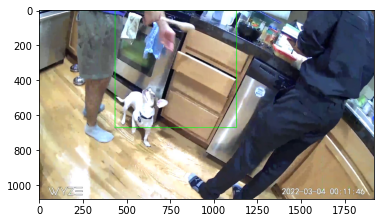

In [ ]:
img, label = our_dataset[6]
print(our_dataset.classes[label])
plt.imshow(img)
print(type(img))

In [ ]:
wyze_dataset = DogBreedDataset(our_dataset, test_transform)
len(wyze_dataset)


1817

0


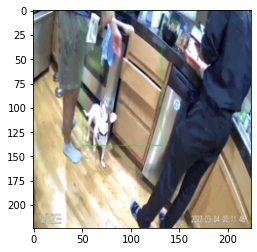

In [ ]:
img, label = wyze_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

In [ ]:
wyze_dl = DataLoader(wyze_dataset, 32, num_workers=workers, shuffle=True, pin_memory = True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
wyze_dl = DeviceDataLoader(wyze_dl, device)


# moving model to gpu
to_device(saved_model_34_65epoch, device);

cuda


In [ ]:
# check the model 
def try_batch(dl):
    for imgs, labels in dl:
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        saved_model.eval()
        outs = saved_model(imgs)                                  # Change model object here
        print("outs.shape :", outs.shape)
        print("outs : ", outs)
        _, preds = torch.max(outs, dim=1)
        print(preds)
        print("preds.shape: ", preds.shape)
        
        labelslist = labels.detach().tolist()
        print(labelslist)
        predlist = preds.detach().tolist()
        print(predlist)

        labelslist = [our_dataset.classes[i] for i in labelslist]
        print(labelslist)
        predlist = [dataset.classes[i] for i in predlist]
        print(predlist)
        
        labelsarray = np.array(labelslist)
        predarray = np.array(predlist)
        print(((np.sum(labelsarray == predarray)) / len(preds)) * 100)
        break
        
try_batch(wyze_dl)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-40-865afec777ca>", line 29, in <module>
    try_batch(wyze_dl)
  File "<ipython-input-40-865afec777ca>", line 3, in try_batch
    for imgs, labels in dl:
  File "<ipython-input-25-92acd5ebf5ad>", line 10, in __iter__
    for batch in self.dl:
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 530, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1207, in _next_data
    idx, data = self._get_data()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1163, in _get_data
    success, data = self._try_get_data()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1011, in _try_get_data
    data = self._d

KeyboardInterrupt: ignored

In [ ]:
evaluate_wyze(saved_model, wyze_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


['n02110185-Siberian_husky', 'n02110185-Siberian_husky', 'n02097047-miniature_schnauzer', 'n02110185-Siberian_husky', 'n02097047-miniature_schnauzer', 'n02097047-miniature_schnauzer', 'n02113186-Cardigan', 'n02097047-miniature_schnauzer', 'n02097047-miniature_schnauzer', 'n02097047-miniature_schnauzer', 'n02097047-miniature_schnauzer', 'n02097047-miniature_schnauzer', 'n02099712-Labrador_retriever', 'n02086646-Blenheim_spaniel', 'n02107142-Doberman', 'n02099712-Labrador_retriever', 'n02097047-miniature_schnauzer', 'n02097047-miniature_schnauzer', 'n02097047-miniature_schnauzer', 'n02099712-Labrador_retriever', 'n02097047-miniature_schnauzer', 'n02097047-miniature_schnauzer', 'n02085620-Chihuahua', 'n02113023-Pembroke', 'n02097047-miniature_schnauzer', 'n02099712-Labrador_retriever', 'n02113799-standard_poodle', 'n02097047-miniature_schnauzer', 'n02097047-miniature_schnauzer', 'n02097047-miniature_schnauzer', 'n02097047-miniature_schnauzer', 'n02099712-Labrador_retriever']
['n02091831-S

{'val_acc': 4.00219298245614}

In [ ]:
cd /content/drive/My Drive/UW/2021-22_Senior/Capstone/ENGINE: Wyze/

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-45-165b8943de91>", line 1, in <module>
    get_ipython().magic('cd /content/drive/My Drive/UW/2021-22_Senior/Capstone/ENGINE: Wyze/')
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2160, in magic
    return self.run_line_magic(magic_name, magic_arg_s)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2081, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-84>", line 2, in cd
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/magic.py", line 188, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/magics/osm.py", line 288, in cd
    oldcwd = py3compat.getcwd()
FileNotFoundError: [Errno 2] No such file or di

FileNotFoundError: ignored

In [ ]:
! git clone https://github.com/DequanWang/tent.git

Cloning into 'tent'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 58 (delta 28), reused 52 (delta 24), pack-reused 0
Unpacking objects: 100% (58/58), done.


In [ ]:
import sys
sys.path.insert(0,"/content/drive/MyDrive/UW/2021-22_Senior/Capstone/ENGINE: Wyze/")
import tent.tent as tent

In [ ]:
model_to_tent = DogBreedPretrainedResnet34()
model_to_tent.load_state_dict(torch.load("/content/drive/MyDrive/UW/2021-22_Senior/Capstone/ENGINE: Wyze/dog-breed-classifier-resnet34-pretrained-finetuned-65-epochs.pth"))

<All keys matched successfully>

In [ ]:
model_to_tent = DogBreedPretrainedResnet18()
model_to_tent.load_state_dict(torch.load("/content/drive/MyDrive/UW/2021-22_Senior/Capstone/ENGINE: Wyze/dog-breed-classifier-resnet18-pretrained-finetuned-35-epochs.pth"))

<All keys matched successfully>

In [ ]:
model_to_tent = tent.configure_model(model_to_tent)
params, param_names = tent.collect_params(model_to_tent)
optimizer = torch.optim.SGD(params, lr=1e-3)
tented_model = tent.Tent(model_to_tent, optimizer)
print(tent.check_model(tented_model))

None


In [ ]:

# wyze cam tented
def try_batch(batch):
        imgs, labels = batch
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = tented_model(imgs)                                  # Change model object here
        print("outs.shape :", outs.shape)
        print("outs : ", outs)
        _, preds = torch.max(outs, dim=1)
        print(preds)
        print("preds.shape: ", preds.shape)
        
        labelslist = labels.detach().tolist()
        print(labelslist)
        predlist = preds.detach().tolist()
        print(predlist)

        labelslist = [our_dataset.classes[i] for i in labelslist]
        print(labelslist)
        predlist = [dataset.classes[i] for i in predlist]
        print(predlist)
        
        labelsarray = np.array(labelslist)
        predarray = np.array(predlist)
        acc = (((np.sum(labelsarray == predarray)) / len(preds)) * 100)
        print(acc)
        return {'val_acc':acc, 'val_loss': 0}

to_device(tented_model, device)
outputss = [try_batch(batch) for batch in wyze_dl]
batch_acc = [x['val_acc'] for x in outputss]
epoch_acc = statistics.mean(batch_acc)
print("val_acc: " + str(epoch_acc))
      

images shape :  torch.Size([32, 3, 224, 224])
labels :  tensor([12,  7,  7,  4,  4,  7,  7, 12,  7,  7,  7,  7, 18,  7,  7,  7,  7,  7,
         0,  7, 18,  7,  7,  6,  7, 10, 23,  7,  7,  7,  7,  7],
       device='cuda:0')
outs.shape : torch.Size([32, 120])
outs :  tensor([[-11.0516,  -8.6598,  -7.6414,  ...,  -6.5135,  -6.7075,  -9.5382],
        [ -5.1922,  -9.2665,  -8.1121,  ...,  -6.2625,  -8.8035,  -9.1037],
        [ -6.5263, -10.8794,  -8.6906,  ...,  -8.4756, -13.5922, -11.7594],
        ...,
        [ -6.1775,  -7.7448,  -7.2449,  ...,  -5.1386,  -8.1342,  -7.6749],
        [ -9.0505,  -7.1480,  -8.2525,  ...,  -7.1878,  -6.2470,  -5.2303],
        [-10.2191,  -8.2618, -11.0862,  ...,  -7.7955, -10.1472,  -8.6991]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([ 33, 101,  28,   8,  60, 104,   7, 112,  41, 105,  26,  42, 118,   5,
         28, 113,  70,  84,  17,  13,  71, 116,  69, 112,  25,  68,  68, 116,
         16,  71,  38,  81], device='cuda:0')
preds

In [ ]:
# corrupt stanford tented
def try_batch(batch):
        imgs, labels = batch
        # print("images shape : ", imgs.shape)
        # print("labels : ", labels)
        outs = tented_model(imgs)                                  # Change model object here
        # print("outs.shape :", outs.shape)
        # print("outs : ", outs)
        _, preds = torch.max(outs, dim=1)
        # print(preds)
        # print("preds.shape: ", preds.shape)
        
        labelslist = labels.detach().tolist()
        # print(labelslist)
        predlist = preds.detach().tolist()
        # print(predlist)

        labelslist = [dataset.classes[i] for i in labelslist]
        # print(labelslist)
        predlist = [dataset.classes[i] for i in predlist]
        # print(predlist)
        
        labelsarray = np.array(labelslist)
        predarray = np.array(predlist)
        acc = (((np.sum(labelsarray == predarray)) / len(preds)) * 100)
        # print(acc)
        return {'val_acc':acc, 'val_loss': 0}

to_device(tented_model, device)
outputss = [try_batch(batch) for batch in corrupt_test_dl]
batch_acc = [x['val_acc'] for x in outputss]
epoch_acc = statistics.mean(batch_acc)
print("val_acc: " + str(epoch_acc))
      


val_acc: 34.575892857142854


In [ ]:
# non corrupt stanford tented
def try_batch(batch):
        imgs, labels = batch
        # print("images shape : ", imgs.shape)
        # print("labels : ", labels)
        outs = tented_model(imgs)                                  # Change model object here
        # print("outs.shape :", outs.shape)
        # print("outs : ", outs)
        _, preds = torch.max(outs, dim=1)
        # print(preds)
        # print("preds.shape: ", preds.shape)
        
        labelslist = labels.detach().tolist()
        # print(labelslist)
        predlist = preds.detach().tolist()
        # print(predlist)

        labelslist = [dataset.classes[i] for i in labelslist]
        # print(labelslist)
        predlist = [dataset.classes[i] for i in predlist]
        # print(predlist)
        
        labelsarray = np.array(labelslist)
        predarray = np.array(predlist)
        acc = (((np.sum(labelsarray == predarray)) / len(preds)) * 100)
        # print(acc)
        return {'val_acc':acc, 'val_loss': 0}

to_device(tented_model, device)
outputss = [try_batch(batch) for batch in test_dl]
batch_acc = [x['val_acc'] for x in outputss]
epoch_acc = statistics.mean(batch_acc)
print("val_acc: " + str(epoch_acc))
      


val_acc: 75.8312074829932


In [ ]:
google_dataset = ImageFolder('./Images/dataset/google')

In [ ]:
google_dataset.classes

['n02085620-Chihuahua',
 'n02086646-Blenheim_spaniel',
 'n02087046-toy_terrier',
 'n02088364-beagle',
 'n02092339-Weimaraner',
 'n02093428-American_Staffordshire_terrier',
 'n02095314-wire-haired_fox_terrier',
 'n02097047-miniature_schnauzer',
 'n02098286-West_Highland_white_terrier',
 'n02099601-golden_retriever',
 'n02099712-Labrador_retriever',
 'n02105641-Old_English_sheepdog',
 'n02106030-collie',
 'n02106550-Rottweiler',
 'n02106662-German_shepherd',
 'n02107142-Doberman',
 'n02108089-boxer',
 'n02110063-malamute',
 'n02110185-Siberian_husky',
 'n02110958-pug',
 'n02112018-Pomeranian',
 'n02113023-Pembroke',
 'n02113186-Cardigan',
 'n02113799-standard_poodle',
 'n02115641-dingo']

In [ ]:
len(google_dataset)

676

In [ ]:
googles_dataset = DogBreedDataset(google_dataset, test_transform)
corrupt_googles_dataset = DogBreedDataset(google_dataset, corrupt_transform)

print(len(googles_dataset))
print(len(corrupt_googles_dataset))

676
676


2


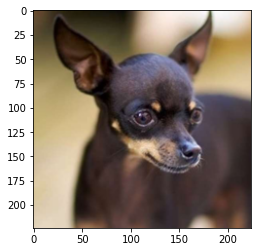

In [ ]:
img, label = googles_dataset[70]
print(label)
plt.imshow(img.permute(1,2,0))

2


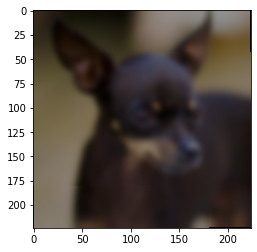

In [ ]:
img, label = corrupt_googles_dataset[70]
print(label)
plt.imshow(img.permute(1,2,0))

In [ ]:
google_dl = DataLoader(googles_dataset, 15, num_workers=4, shuffle=True, pin_memory = True)
corrupt_google_dl = DataLoader(corrupt_googles_dataset, 15, num_workers=workers, shuffle=True, pin_memory = True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
google_dl = DeviceDataLoader(google_dl, device)
corrupt_google_dl = DeviceDataLoader(corrupt_google_dl, device)

cuda


In [ ]:
# normal google non tented
def try_batch(batch):
        imgs, labels = batch
        saved_model.eval()
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = saved_model(imgs)                                  # Change model object here
        # print("outs.shape :", outs.shape)
        # print("outs : ", outs)
        _, preds = torch.max(outs, dim=1)
        # print(preds)
        # print("preds.shape: ", preds.shape)
        
        labelslist = labels.detach().tolist()
        # print(labelslist)
        predlist = preds.detach().tolist()
        # print(predlist)

        labelslist = [google_dataset.classes[i] for i in labelslist]
        print(labelslist)
        predlist = [dataset.classes[i] for i in predlist]
        print(predlist)
        
        labelsarray = np.array(labelslist)
        predarray = np.array(predlist)
        acc = (((np.sum(labelsarray == predarray)) / len(preds)) * 100)
        print(acc)
        return {'val_acc':acc, 'val_loss': 0}

outputss = [try_batch(batch) for batch in google_dl]
batch_acc = [x['val_acc'] for x in outputss]
epoch_acc = statistics.mean(batch_acc)
print("val_acc: " + str(epoch_acc))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images shape :  torch.Size([15, 3, 224, 224])
labels :  tensor([12, 11,  4, 14,  7, 24, 14,  4, 14, 20, 21,  4, 15,  5, 18],
       device='cuda:0')
['n02106030-collie', 'n02105641-Old_English_sheepdog', 'n02092339-Weimaraner', 'n02106662-German_shepherd', 'n02097047-miniature_schnauzer', 'n02115641-dingo', 'n02106662-German_shepherd', 'n02092339-Weimaraner', 'n02106662-German_shepherd', 'n02112018-Pomeranian', 'n02113023-Pembroke', 'n02092339-Weimaraner', 'n02107142-Doberman', 'n02093428-American_Staffordshire_terrier', 'n02110185-Siberian_husky']
['n02106030-collie', 'n02097474-Tibetan_terrier', 'n02092339-Weimaraner', 'n02106662-German_shepherd', 'n02097209-standard_schnauzer', 'n02115641-dingo', 'n02106662-German_shepherd', 'n02092339-Weimaraner', 'n02111129-Leonberg', 'n02112018-Pomeranian', 'n02113023-Pembroke', 'n02092339-Weimaraner', 'n02107142-Doberman', 'n02093256-Staffordshire_bullterrier', 'n02110185-Siberian_husky']
73.33333333333333
images shape :  torch.Size([15, 3, 224,

In [ ]:
# normal google tented
def try_batch(batch):
        imgs, labels = batch
        # print("images shape : ", imgs.shape)
        # print("labels : ", labels)
        outs = tented_model(imgs)                                  # Change model object here
        # print("outs.shape :", outs.shape)
        # print("outs : ", outs)
        _, preds = torch.max(outs, dim=1)
        # print(preds)
        # print("preds.shape: ", preds.shape)
        
        labelslist = labels.detach().tolist()
        # print(labelslist)
        predlist = preds.detach().tolist()
        # print(predlist)

        labelslist = [google_dataset.classes[i] for i in labelslist]
        # print(labelslist)
        predlist = [dataset.classes[i] for i in predlist]
        # print(predlist)
        
        labelsarray = np.array(labelslist)
        predarray = np.array(predlist)
        acc = (((np.sum(labelsarray == predarray)) / len(preds)) * 100)
        # print(acc)
        return {'val_acc':acc, 'val_loss': 0}

to_device(tented_model, device)
outputss = [try_batch(batch) for batch in google_dl]
batch_acc = [x['val_acc'] for x in outputss]
epoch_acc = statistics.mean(batch_acc)
print("val_acc: " + str(epoch_acc))

val_acc: 59.565217391304344


In [ ]:
# corrupt google non tented
def try_batch(batch):
        imgs, labels = batch
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        saved_model_18.eval()
        outs = saved_model_18(imgs)                                  # Change model object here
        # print("outs.shape :", outs.shape)
        # print("outs : ", outs)
        _, preds = torch.max(outs, dim=1)
        # print(preds)
        # print("preds.shape: ", preds.shape)
        
        labelslist = labels.detach().tolist()
        # print(labelslist)
        predlist = preds.detach().tolist()
        # print(predlist)

        labelslist = [google_dataset.classes[i] for i in labelslist]
        print(labelslist)
        predlist = [dataset.classes[i] for i in predlist]
        print(predlist)
        
        labelsarray = np.array(labelslist)
        predarray = np.array(predlist)
        acc = (((np.sum(labelsarray == predarray)) / len(preds)) * 100)
        print(acc)
        return {'val_acc':acc, 'val_loss': 0}

outputss = [try_batch(batch) for batch in corrupt_google_dl]
batch_acc = [x['val_acc'] for x in outputss]
epoch_acc = statistics.mean(batch_acc)
print("val_acc: " + str(epoch_acc))

images shape :  torch.Size([15, 3, 224, 224])
labels :  tensor([ 0,  9, 18, 24,  7, 24, 18, 12, 23,  9, 22, 14,  7, 22, 13],
       device='cuda:0')
['n02085620-Chihuahua', 'n02099601-golden_retriever', 'n02110185-Siberian_husky', 'n02115641-dingo', 'n02097047-miniature_schnauzer', 'n02115641-dingo', 'n02110185-Siberian_husky', 'n02106030-collie', 'n02113799-standard_poodle', 'n02099601-golden_retriever', 'n02113186-Cardigan', 'n02106662-German_shepherd', 'n02097047-miniature_schnauzer', 'n02113186-Cardigan', 'n02106550-Rottweiler']
['n02085620-Chihuahua', 'n02094258-Norwich_terrier', 'n02095570-Lakeland_terrier', 'n02115913-dhole', 'n02097047-miniature_schnauzer', 'n02112018-Pomeranian', 'n02109961-Eskimo_dog', 'n02112350-keeshond', 'n02116738-African_hunting_dog', 'n02093991-Irish_terrier', 'n02101388-Brittany_spaniel', 'n02107312-miniature_pinscher', 'n02110627-affenpinscher', 'n02085620-Chihuahua', 'n02106550-Rottweiler']
20.0
images shape :  torch.Size([15, 3, 224, 224])
labels : 

In [ ]:
# corrupt google tented
def try_batch(batch):
        imgs, labels = batch
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = tented_model(imgs)                                  # Change model object here
        # print("outs.shape :", outs.shape)
        # print("outs : ", outs)
        _, preds = torch.max(outs, dim=1)
        # print(preds)
        # print("preds.shape: ", preds.shape)
        
        labelslist = labels.detach().tolist()
        # print(labelslist)
        predlist = preds.detach().tolist()
        # print(predlist)

        labelslist = [google_dataset.classes[i] for i in labelslist]
        print(labelslist)
        predlist = [dataset.classes[i] for i in predlist]
        print(predlist)
        
        labelsarray = np.array(labelslist)
        predarray = np.array(predlist)
        acc = (((np.sum(labelsarray == predarray)) / len(preds)) * 100)
        print(acc)
        return {'val_acc':acc, 'val_loss': 0}
to_device(tented_model, device)
outputss = [try_batch(batch) for batch in corrupt_google_dl]
batch_acc = [x['val_acc'] for x in outputss]
epoch_acc = statistics.mean(batch_acc)
print("val_acc: " + str(epoch_acc))

images shape :  torch.Size([15, 3, 224, 224])
labels :  tensor([16, 18, 23,  7, 14, 14,  5, 17,  0,  7, 19, 20, 23, 19, 17],
       device='cuda:0')
['n02108089-boxer', 'n02110185-Siberian_husky', 'n02113799-standard_poodle', 'n02097047-miniature_schnauzer', 'n02106662-German_shepherd', 'n02106662-German_shepherd', 'n02093428-American_Staffordshire_terrier', 'n02110063-malamute', 'n02085620-Chihuahua', 'n02097047-miniature_schnauzer', 'n02110958-pug', 'n02112018-Pomeranian', 'n02113799-standard_poodle', 'n02110958-pug', 'n02110063-malamute']
['n02108089-boxer', 'n02095889-Sealyham_terrier', 'n02101388-Brittany_spaniel', 'n02097047-miniature_schnauzer', 'n02105056-groenendael', 'n02106662-German_shepherd', 'n02105412-kelpie', 'n02109961-Eskimo_dog', 'n02085620-Chihuahua', 'n02092002-Scottish_deerhound', 'n02110958-pug', 'n02097298-Scotch_terrier', 'n02113799-standard_poodle', 'n02110958-pug', 'n02110063-malamute']
53.333333333333336
images shape :  torch.Size([15, 3, 224, 224])
labels :

In [ ]:
youtube_dataset = ImageFolder('./Images/dataset/yt')

In [ ]:
youtube_dataset.classes

['n02085620-Chihuahua',
 'n02086646-Blenheim_spaniel',
 'n02087046-toy_terrier',
 'n02088364-beagle',
 'n02092339-Weimaraner',
 'n02093428-American_Staffordshire_terrier',
 'n02095314-wire-haired_fox_terrier',
 'n02097047-miniature_schnauzer',
 'n02098286-West_Highland_white_terrier',
 'n02099601-golden_retriever',
 'n02099712-Labrador_retriever',
 'n02105641-Old_English_sheepdog',
 'n02106030-collie',
 'n02106550-Rottweiler',
 'n02106662-German_shepherd',
 'n02107142-Doberman',
 'n02108089-boxer',
 'n02110063-malamute',
 'n02110185-Siberian_husky',
 'n02110958-pug',
 'n02112018-Pomeranian',
 'n02113023-Pembroke',
 'n02113186-Cardigan',
 'n02113799-standard_poodle',
 'n02115641-dingo']

In [ ]:
len(youtube_dataset)

500

In [ ]:
youtubes_dataset = DogBreedDataset(youtube_dataset, test_transform)
corrupt_youtubes_dataset = DogBreedDataset(youtube_dataset, corrupt_transform)

In [ ]:
youtube_dl = DataLoader(youtubes_dataset, 10, num_workers=workers, shuffle=True, pin_memory = True)
corrupt_youtube_dl = DataLoader(corrupt_youtubes_dataset, 10, num_workers=workers, shuffle=True, pin_memory = True)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
youtube_dl = DeviceDataLoader(youtube_dl, device)
corrupt_youtube_dl = DeviceDataLoader(corrupt_youtube_dl, device)

cuda


In [ ]:
# noncorrupt youtube non tented
def try_batch(batch):
        imgs, labels = batch
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        saved_model.eval()
        outs = saved_model(imgs)                                  # Change model object here
        # print("outs.shape :", outs.shape)
        # print("outs : ", outs)
        _, preds = torch.max(outs, dim=1)
        # print(preds)
        # print("preds.shape: ", preds.shape)
        
        labelslist = labels.detach().tolist()
        # print(labelslist)
        predlist = preds.detach().tolist()
        # print(predlist)

        labelslist = [youtube_dataset.classes[i] for i in labelslist]
        print(labelslist)
        predlist = [dataset.classes[i] for i in predlist]
        print(predlist)
        
        labelsarray = np.array(labelslist)
        predarray = np.array(predlist)
        acc = (((np.sum(labelsarray == predarray)) / len(preds)) * 100)
        print(acc)
        return {'val_acc':acc, 'val_loss': 0}

outputss = [try_batch(batch) for batch in youtube_dl]
batch_acc = [x['val_acc'] for x in outputss]
epoch_acc = statistics.mean(batch_acc)
print("val_acc: " + str(epoch_acc))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images shape :  torch.Size([10, 3, 224, 224])
labels :  tensor([12, 16, 22, 13, 16, 13,  3,  5,  1, 14], device='cuda:0')
['n02106030-collie', 'n02108089-boxer', 'n02113186-Cardigan', 'n02106550-Rottweiler', 'n02108089-boxer', 'n02106550-Rottweiler', 'n02088364-beagle', 'n02093428-American_Staffordshire_terrier', 'n02086646-Blenheim_spaniel', 'n02106662-German_shepherd']
['n02105855-Shetland_sheepdog', 'n02088364-beagle', 'n02113186-Cardigan', 'n02106550-Rottweiler', 'n02087394-Rhodesian_ridgeback', 'n02108000-EntleBucher', 'n02088238-basset', 'n02093256-Staffordshire_bullterrier', 'n02101006-Gordon_setter', 'n02091032-Italian_greyhound']
20.0
images shape :  torch.Size([10, 3, 224, 224])
labels :  tensor([11, 24,  6,  5, 16, 10,  6,  1, 14, 20], device='cuda:0')
['n02105641-Old_English_sheepdog', 'n02115641-dingo', 'n02095314-wire-haired_fox_terrier', 'n02093428-American_Staffordshire_terrier', 'n02108089-boxer', 'n02099712-Labrador_retriever', 'n02095314-wire-haired_fox_terrier', 'n0

In [ ]:
# noncorrupt youtube tented
def try_batch(batch):
        imgs, labels = batch
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = tented_model(imgs)                                  # Change model object here
        print("outs.shape :", outs.shape)
        # print("outs : ", outs)
        _, preds = torch.max(outs, dim=1)
        # print(preds)
        print("preds.shape: ", preds.shape)
        
        labelslist = labels.detach().tolist()
        # print(labelslist)
        predlist = preds.detach().tolist()
        # print(predlist)

        labelslist = [youtube_dataset.classes[i] for i in labelslist]
        print(labelslist)
        predlist = [dataset.classes[i] for i in predlist]
        print(predlist)
        
        labelsarray = np.array(labelslist)
        predarray = np.array(predlist)
        acc = (((np.sum(labelsarray == predarray)) / len(preds)) * 100)
        print(acc)
        return {'val_acc':acc, 'val_loss': 0}
to_device(tented_model, device)
outputss = [try_batch(batch) for batch in youtube_dl]
batch_acc = [x['val_acc'] for x in outputss]
epoch_acc = statistics.mean(batch_acc)
print("val_acc: " + str(epoch_acc))

images shape :  torch.Size([10, 3, 224, 224])
labels :  tensor([14, 14,  3,  1,  3, 15, 18, 13, 18, 12], device='cuda:0')
outs.shape : torch.Size([10, 120])
preds.shape:  torch.Size([10])
['n02106662-German_shepherd', 'n02106662-German_shepherd', 'n02088364-beagle', 'n02086646-Blenheim_spaniel', 'n02088364-beagle', 'n02107142-Doberman', 'n02110185-Siberian_husky', 'n02106550-Rottweiler', 'n02110185-Siberian_husky', 'n02106030-collie']
['n02096177-cairn', 'n02106662-German_shepherd', 'n02092002-Scottish_deerhound', 'n02086646-Blenheim_spaniel', 'n02090379-redbone', 'n02085936-Maltese_dog', 'n02099712-Labrador_retriever', 'n02101006-Gordon_setter', 'n02110063-malamute', 'n02106166-Border_collie']
20.0
images shape :  torch.Size([10, 3, 224, 224])
labels :  tensor([20,  3, 13, 24, 23, 13,  3,  8, 14, 21], device='cuda:0')
outs.shape : torch.Size([10, 120])
preds.shape:  torch.Size([10])
['n02112018-Pomeranian', 'n02088364-beagle', 'n02106550-Rottweiler', 'n02115641-dingo', 'n02113799-stan

In [ ]:
# corrupt youtube non tented
def try_batch(batch):
        imgs, labels = batch
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        saved_model_18.eval()
        outs = saved_model_18(imgs)                                  # Change model object here
        # print("outs.shape :", outs.shape)
        # print("outs : ", outs)
        _, preds = torch.max(outs, dim=1)
        # print(preds)
        # print("preds.shape: ", preds.shape)
        
        labelslist = labels.detach().tolist()
        # print(labelslist)
        predlist = preds.detach().tolist()
        # print(predlist)

        labelslist = [youtube_dataset.classes[i] for i in labelslist]
        print(labelslist)
        predlist = [dataset.classes[i] for i in predlist]
        print(predlist)
        
        labelsarray = np.array(labelslist)
        predarray = np.array(predlist)
        acc = (((np.sum(labelsarray == predarray)) / len(preds)) * 100)
        print(acc)
        return {'val_acc':acc, 'val_loss': 0}

outputss = [try_batch(batch) for batch in corrupt_youtube_dl]
batch_acc = [x['val_acc'] for x in outputss]
epoch_acc = statistics.mean(batch_acc)
print("val_acc: " + str(epoch_acc))

images shape :  torch.Size([10, 3, 224, 224])
labels :  tensor([12,  8, 10, 16,  3, 14, 10, 14, 15,  8], device='cuda:0')
['n02106030-collie', 'n02098286-West_Highland_white_terrier', 'n02099712-Labrador_retriever', 'n02108089-boxer', 'n02088364-beagle', 'n02106662-German_shepherd', 'n02099712-Labrador_retriever', 'n02106662-German_shepherd', 'n02107142-Doberman', 'n02098286-West_Highland_white_terrier']
['n02085936-Maltese_dog', 'n02085936-Maltese_dog', 'n02085936-Maltese_dog', 'n02085936-Maltese_dog', 'n02085936-Maltese_dog', 'n02085936-Maltese_dog', 'n02085936-Maltese_dog', 'n02085936-Maltese_dog', 'n02109961-Eskimo_dog', 'n02085936-Maltese_dog']
0.0
images shape :  torch.Size([10, 3, 224, 224])
labels :  tensor([ 4, 18, 11, 24,  1,  2, 14,  5, 20, 19], device='cuda:0')
['n02092339-Weimaraner', 'n02110185-Siberian_husky', 'n02105641-Old_English_sheepdog', 'n02115641-dingo', 'n02086646-Blenheim_spaniel', 'n02087046-toy_terrier', 'n02106662-German_shepherd', 'n02093428-American_Staffo

In [ ]:
# corrupt youtube tented
def try_batch(batch):
        imgs, labels = batch
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = tented_model(imgs)                                  # Change model object here
        print("outs.shape :", outs.shape)
        # print("outs : ", outs)
        _, preds = torch.max(outs, dim=1)
        # print(preds)
        print("preds.shape: ", preds.shape)
        
        labelslist = labels.detach().tolist()
        # print(labelslist)
        predlist = preds.detach().tolist()
        # print(predlist)

        labelslist = [youtube_dataset.classes[i] for i in labelslist]
        print(labelslist)
        predlist = [dataset.classes[i] for i in predlist]
        print(predlist)
        
        labelsarray = np.array(labelslist)
        predarray = np.array(predlist)
        acc = (((np.sum(labelsarray == predarray)) / len(preds)) * 100)
        print(acc)
        return {'val_acc':acc, 'val_loss': 0}
to_device(tented_model, device)
outputss = [try_batch(batch) for batch in corrupt_youtube_dl]
batch_acc = [x['val_acc'] for x in outputss]
epoch_acc = statistics.mean(batch_acc)
print("val_acc: " + str(epoch_acc))

images shape :  torch.Size([10, 3, 224, 224])
labels :  tensor([ 8, 10, 14,  6, 17, 20,  8,  0, 12,  4], device='cuda:0')
outs.shape : torch.Size([10, 120])
preds.shape:  torch.Size([10])
['n02098286-West_Highland_white_terrier', 'n02099712-Labrador_retriever', 'n02106662-German_shepherd', 'n02095314-wire-haired_fox_terrier', 'n02110063-malamute', 'n02112018-Pomeranian', 'n02098286-West_Highland_white_terrier', 'n02085620-Chihuahua', 'n02106030-collie', 'n02092339-Weimaraner']
['n02108551-Tibetan_mastiff', 'n02105412-kelpie', 'n02095314-wire-haired_fox_terrier', 'n02100735-English_setter', 'n02086079-Pekinese', 'n02113624-toy_poodle', 'n02108000-EntleBucher', 'n02101556-clumber', 'n02105251-briard', 'n02088466-bloodhound']
0.0
images shape :  torch.Size([10, 3, 224, 224])
labels :  tensor([14, 10, 23,  2, 20,  7, 21,  2, 22, 24], device='cuda:0')
outs.shape : torch.Size([10, 120])
preds.shape:  torch.Size([10])
['n02106662-German_shepherd', 'n02099712-Labrador_retriever', 'n02113799-st

TESTING DIFFERENT AMOUNTS OF AUGMENTATION


1X AUGMENTATION (2X TOTAL TRAIN DATASET)

2X AUGMENTATION (3X TOTAL TRAIN DATASET)

3X AUGMENTATION (4X TOTAL TRAIN DATASET)